# Cogeneration Power Analysis
Using the UCI CCPP dataset this is a comparison of various regression algorithms to analyze performance and then use SHAP to examine feature importance. 

Did the outliers treatment adversely affect my results? Copy notebook and try all again.

## Dataset Atribution
This data set was obtained from U iversity of California, Irvine database repositiry. 

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP)  of the plant.

A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, he other three of the ambient variables effect the GT performance.
For comparability with our baseline studies, and to allow 5x2 fold statistical tests be carried out, we provide the data shuffled five times. For each shuffling 2-fold CV is carried out and the resulting 10 measurements are used for statistical testing.
We provide the data both in .ods and in .xlsx formats.

### Data Dictionary
**T** = temperature

**AP** = Ambient Pressure

**RH** = Relative Humidity

**V** = Exhaust Vacuum

**EP** = Electrical Energy Output

## Import Required Libraries  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import time
import xgboost as xgb
import tensorflow as tf

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR

random_state = 11


#### Function Row
Functions used in this notebook

In [2]:
# function to plot a boxplot and a histogram along the same scale.
def histogram_boxplot(data, feature, figsize=(12, 7), kde=True, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

## Import Dataset

In [3]:
base_df = pd.read_excel('Data/Folds5x2_pp.xlsx')

In [4]:
# Verify dataset read
base_df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [5]:
# set primary start time
start_time = time.time()

## Basic Dataset Information

In [6]:
base_df.describe().T

,count,mean,std,min,25%,50%,75%,max
AT,9568.0,19.651231,7.452473,1.81,13.5100,20.345,25.72,37.11
V,9568.0,54.305804,12.707893,25.36,41.7400,52.080,66.54,81.56
AP,9568.0,1013.259078,5.938784,992.89,1009.1000,1012.940,1017.26,1033.30
RH,9568.0,73.308978,14.600269,25.56,63.3275,74.975,84.83,100.16
PE,9568.0,454.365009,17.066995,420.26,439.7500,451.550,468.43,495.76


In [7]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [8]:
base_df.shape

(9568, 5)

## Exploratory Data Analysis

In [9]:
# missing values
base_df.isna().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

### Dataset Pair Plot

No missing values identified.

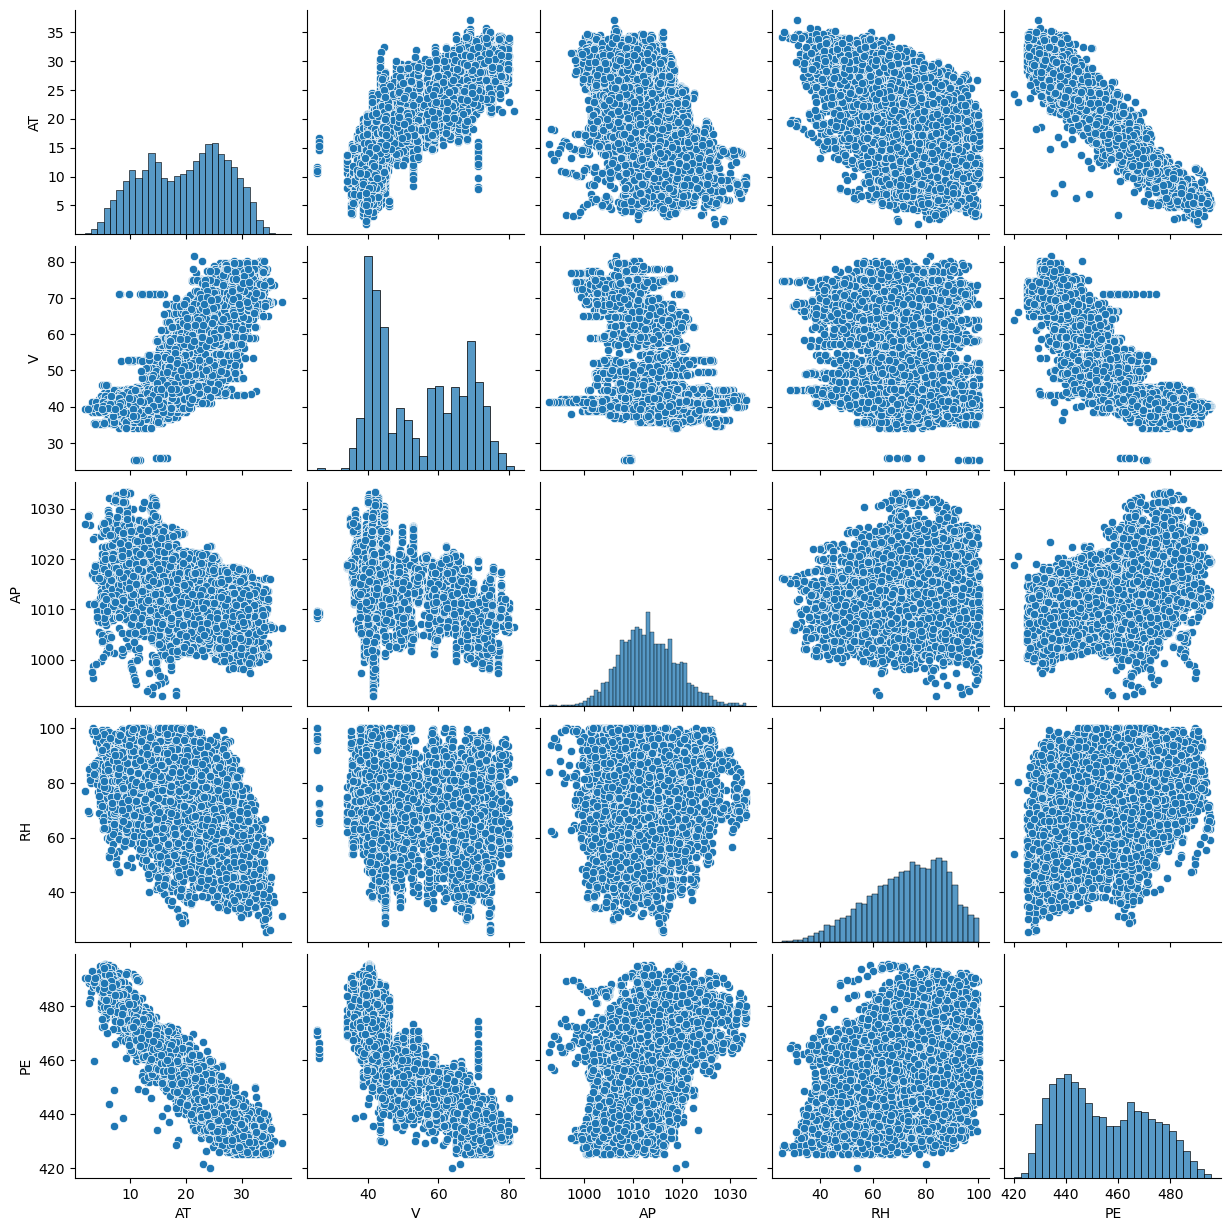

In [10]:
sns.pairplot(data=base_df) ;

#### Pair plot comments:
- AT and V have a negative linear realtionship with PE. AP may have a slight relations but it doesn't appear very strong. RH seems to have an even weaker relationship. 
- There may be a few outliers, we will check closer with box plots

### Correlation Heatmap

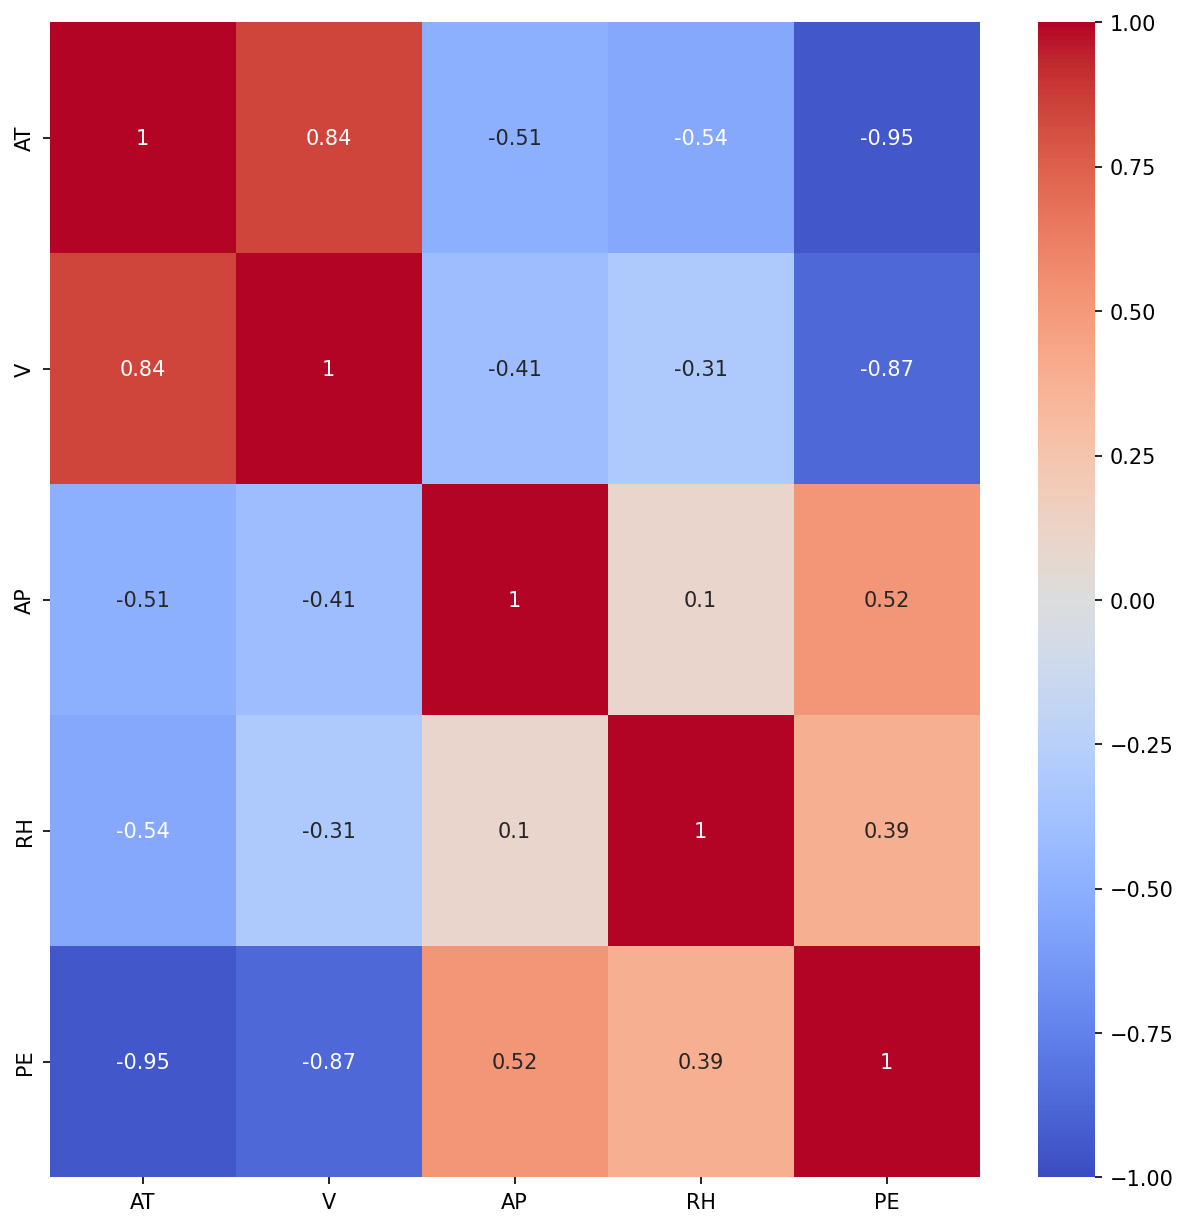

In [11]:
plt.figure(figsize=(10,10), dpi=150)
sns.heatmap(data=base_df.corr(), cmap="coolwarm", annot=True, vmax=1, vmin=-1);

#### Coorelation Heatmap Commnets
- The coorelation heatmap indicates no features are highly correlated to each other, muticolinarity will not be a problem.
- As indicated in the pairplots AT and V have a strong negative correlation to to PE.
- AP and RH have positive correlation that is more defined that in the pairplots.  

### Univarte Analysis

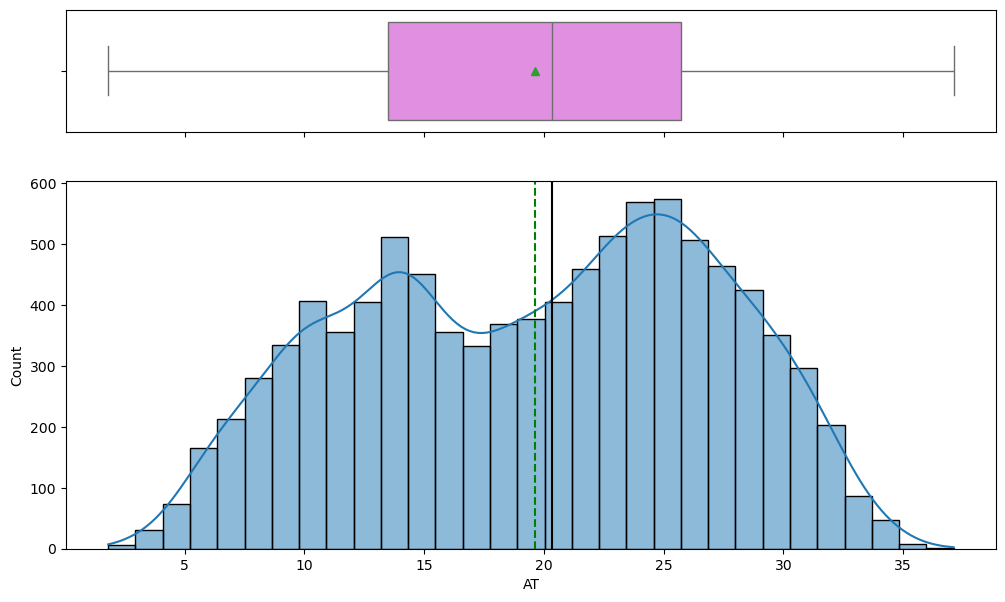

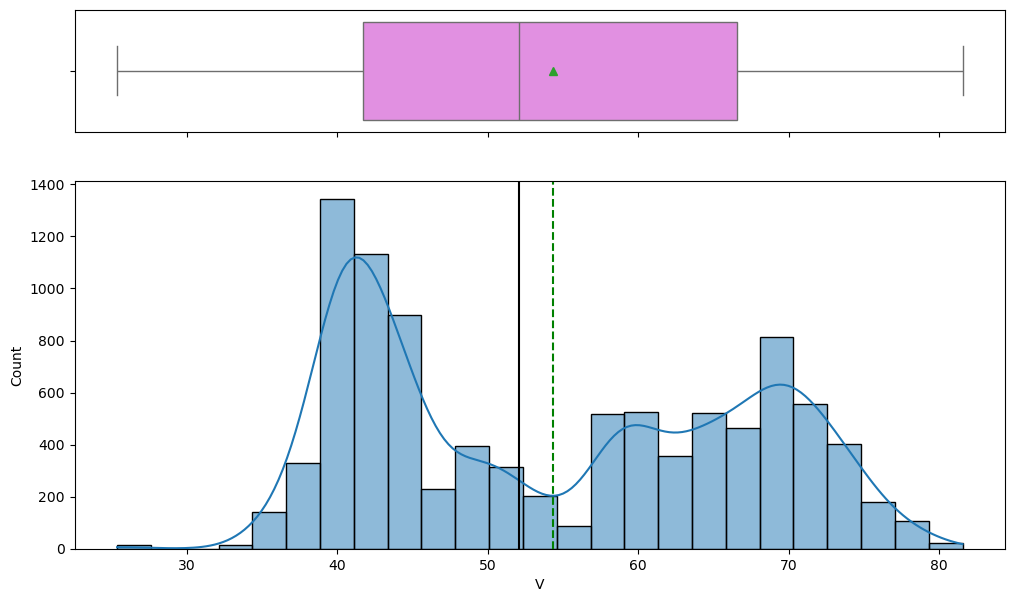

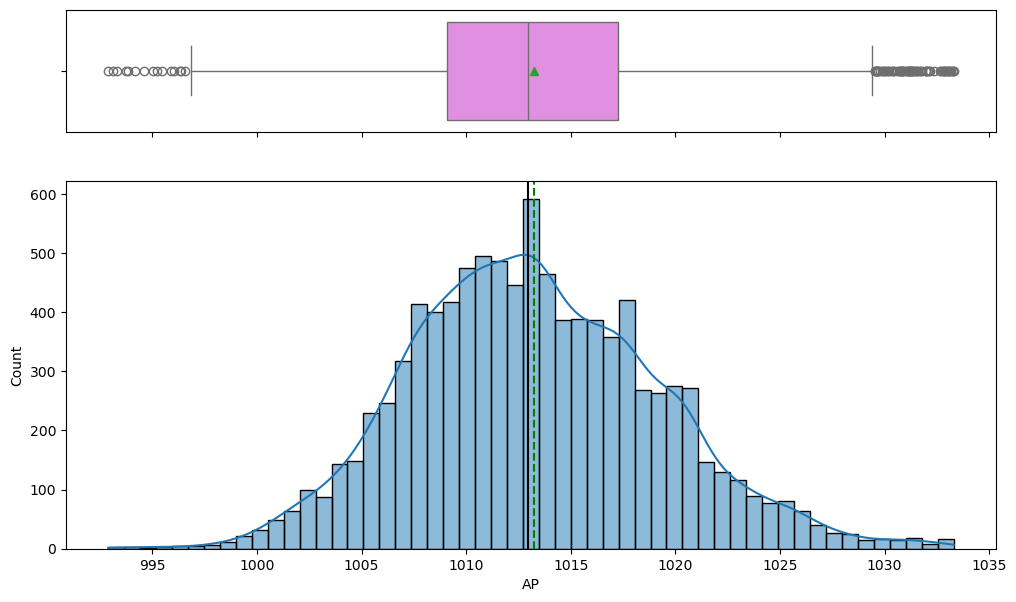

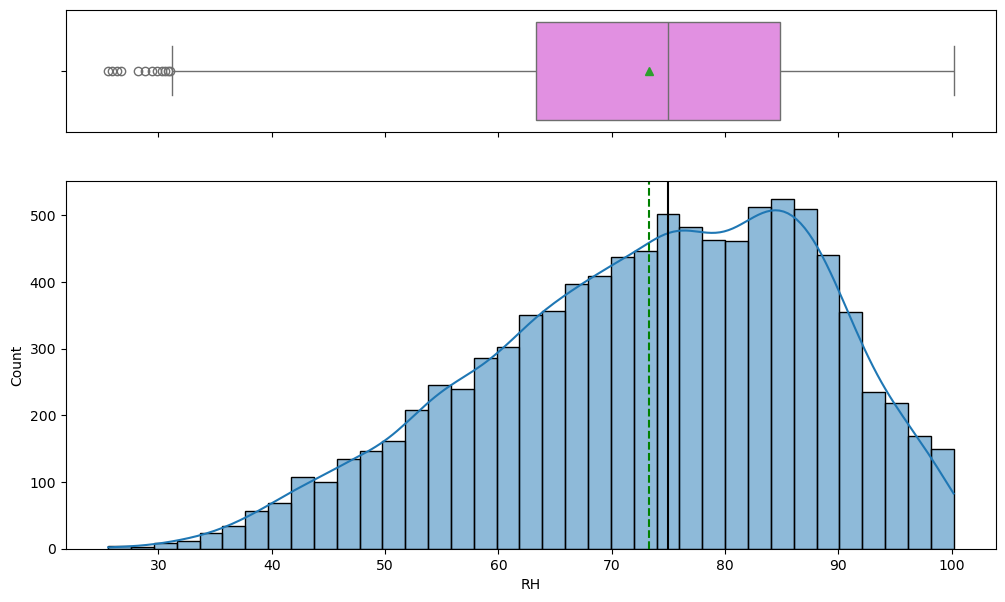

In [12]:
for feature in base_df.columns[:-1]:
    histogram_boxplot(base_df, feature, figsize=(12, 7), kde=True, bins=None)

#### Univariate Comments
- **AT** - No outliers based on box plot, distribution is uneven and has two peaks but not bimodeal
- **V**  - No outliers based on box plots, not a normal distribution.
- **AP** - Outliers on both ends of the box polt, these will need to be addressed, distribtion close to nornmal.
- **RH** - Outliers present on low end of box plot, these will need to be address, distribution is skewed to the left.

#### Train Test Validation Split

In [13]:
y = base_df["RH"]
X = base_df.drop("RH", axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [15]:
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

#### Scaling

In [16]:
scaler = StandardScaler()

In [17]:
X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [18]:
X_train_scaled

array([[-1.16121666, -1.18953979,  0.54565772,  1.48249696],
       [ 0.98575838,  1.3063436 , -0.89130389, -1.14942318],
       [ 1.03525251,  1.85688301,  0.69523619, -0.98135378],
       ...,
       [ 1.38304909,  1.5011136 , -0.31147727, -1.26146945],
       [-1.51436395, -1.43143158,  1.19102996,  1.68266295],
       [-0.66761305, -0.74345365,  1.70026899,  0.58846112]])

## Linear Regression
The first model we will use is LKinear Regression to set a baseline with the simpliest model.

In [19]:
LR_Model = LinearRegression()
LR_Model.fit(X_train_scaled, y_train)

LinearRegression()

In [20]:
LR_y_pred = LR_Model.predict(X_test_scaled)
LR_mae = mean_absolute_error(y_test, LR_y_pred)
LR_mse = mean_squared_error(y_test, LR_y_pred)
LR_rmse = np.sqrt(LR_mse)
LR_r2 = LR_Model.score(X_test_scaled, y_test)

print(f"MAE: {LR_mae:.2f}")
print(f"MSE: {LR_mse:.2f}")
print(f"RMSE: {LR_rmse:.2f}")
print(f"R Squared: {LR_r2:.2f}")

MAE: 8.36
MSE: 108.10
RMSE: 10.40
R Squared: 0.49


## Support Vector Regression - SVR

In [21]:
svr1_model = SVR()

In [22]:
svr1_model.fit(X_train_scaled, y_train)

SVR()

In [23]:
svr1_y_pred = svr1_model.predict(X_test_scaled)
svr1_mae = mean_absolute_error(y_test, svr1_y_pred)
svr1_mse = mean_squared_error(y_test, svr1_y_pred)
svr1_rmse = np.sqrt(svr1_mse)
svr1_r2 = svr1_model.score(X_test_scaled, y_test)

print(f"MAE: {svr1_mae:.2f}")
print(f"MSE: {svr1_mse:.2f}")
print(f"RMSE: {svr1_rmse:.2f}")
print(f"R Squared: {svr1_r2:.2f}")

MAE: 7.79
MSE: 99.09
RMSE: 9.95
R Squared: 0.53


#### SVR with Grid Search

In [24]:
svr2_model_est = SVR()

In [25]:
param_grid = {
    "kernel": ["rbf"],
    "C": [400.0, 500.0, 600.0, 700.0, 800.0, 900.0],
    "epsilon": [2.00, 2.50, 3.00, 3.50],
    "gamma": ["scale", "auto"]
}

In [26]:
svr2_model = GridSearchCV(
    estimator=svr2_model_est,
    param_grid=param_grid,
    scoring="r2",
    cv=10,
    n_jobs=-1,
    verbose=1
)

In [27]:
svr2_model.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [400.0, 500.0, 600.0, 700.0, 800.0, 900.0],
                         'epsilon': [2.0, 2.5, 3.0, 3.5],
                         'gamma': ['scale', 'auto'], 'kernel': ['rbf']},
             scoring='r2', verbose=1)

In [28]:
print("Best parameters:", svr2_model.best_params_)
print("Best CV MSE:", svr2_model.best_score_)

Best parameters: {'C': 900.0, 'epsilon': 3.5, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV MSE: 0.5879388159533419


In [29]:
svr2_y_pred = svr2_model.predict(X_test_scaled)
svr2_mae = mean_absolute_error(y_test, svr2_y_pred)
svr2_mse = mean_squared_error(y_test, svr2_y_pred)
svr2_rmse = np.sqrt(svr2_mse)
svr2_r2 = svr2_model.score(X_test_scaled, y_test)

print(f"MAE: {svr2_mae:.2f}")
print(f"MSE: {svr2_mse:.2f}")
print(f"RMSE: {svr2_rmse:.2f}")
print(f"R Squared: {svr2_r2:.2f}")

MAE: 7.11
MSE: 85.54
RMSE: 9.25
R Squared: 0.60


## XGBoost Regression

In [30]:
# Basic XGBoost regressor
xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",  # standard for regression
    random_state=random_state,
    n_jobs=-1
)

In [31]:
param_grid = {
    "n_estimators": [400, 500],
    "max_depth": [5, 6, 7],
    "learning_rate": [0.1, 0.2, 0.3],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "reg_lambda": [1.0, 2.0, 3.0],   # L2 regularization
    "reg_alpha": [1.0, 2.0],    # L1 regularization
}

In [32]:
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring="r2",  # or "neg_mean_squared_error", "r2", etc.
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [33]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [5, 6, 7], 'n_estimators': [400, 500],
                         'reg_alpha': [1.0, 2.0], 'reg_lambda': [1.0, 2.0, 3.0],
                         'subsample': [0.8, 1.0]},
             scoring='r2', verbose=1)

In [34]:
print("Best parameters found:")
print(grid_search.best_params_)

print("\nBest CV score (negative RMSE):")
print(grid_search.best_score_)


Best parameters found:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8}

Best CV score (negative RMSE):
0.8261450254953179


In [35]:
xgb_y_pred = grid_search.predict(X_test_scaled)
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = grid_search.score(X_test_scaled, y_test)

print(f"MAE: {xgb_mae:.2f}")
print(f"MSE: {xgb_mse:.2f}")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"R Squared: {xgb_r2:.2f}")

MAE: 29.34
MSE: 1073.29
RMSE: 32.76
R Squared: -4.05


## XGBoost Regression - Untuned

In [36]:
# Basic XGBoost regressor
xgb2_reg = xgb.XGBRegressor(
    objective="reg:squarederror",  # standard for regression
    random_state=random_state,
    n_jobs=-1
)

In [37]:
xgb2_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [38]:
xgb2_y_pred = xgb2_reg.predict(X_test_scaled)
xgb2_mae = mean_absolute_error(y_test, xgb2_y_pred)
xgb2_mse = mean_squared_error(y_test, xgb2_y_pred)
xgb2_rmse = np.sqrt(xgb_mse)
xgb2_r2 = xgb2_reg.score(X_test_scaled, y_test)

print(f"MAE: {xgb2_mae:.2f}")
print(f"MSE: {xgb2_mse:.2f}")
print(f"RMSE: {xgb2_rmse:.2f}")
print(f"R Squared: {xgb2_r2:.2f}")

MAE: 29.26
MSE: 1068.66
RMSE: 32.76
R Squared: -4.02


## ANN Regression

#### MinMax Scaling for NN

In [39]:
scaler2 = MinMaxScaler()

In [40]:
X_train_nn = scaler2.fit_transform(X_train)
# X_val_nn = scaler2.transform(X_val)
X_test_nn = scaler2.transform(X_test)

#### Building an ANN

In [41]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
# ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1))

In [42]:
ann.compile(optimizer = 'adam', loss = 'mean_squared_error')

#### Training the ANN

In [43]:
ann.fit(X_train_nn, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5299.8164 
Epoch 2/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4044.1919 
Epoch 3/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1907.5911 
Epoch 4/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 583.3635 
Epoch 5/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 357.7469 
Epoch 6/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 332.9905 
Epoch 7/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 314.4068 
Epoch 8/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 296.8625  
Epoch 9/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 280.8817 
Epoch 10/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 266.5764 
Epoch 11/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 254.2377 
Epoch 12/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 243.5690 
Epoch 13/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 235.2384 
Epoch 14/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 228.300

In [44]:
# calculate total time
end_time = time.time()
total_time = (end_time - start_time)/60
print(f"It took {total_time:.3f} minutes to run this notebook.")

It took 3.400 minutes to run this notebook.
